In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import utile
import matplotlib.pyplot as plt
from torch.utils.data import  Dataset,random_split,DataLoader

In [11]:
batch_size = 256
num_worker = 0

In [12]:
# 定义一个名为 plot_series 的函数，用于绘制时间序列图
def plot_series(plot_series, format='-', start=0, end=None, label=None):
    # 使用 matplotlib 绘制时间序列图
    plt.plot(plot_series[start:end], format, label=label)
    plt.xlabel("Time")  # x轴标签
    plt.ylabel("Value")  # y轴标签
    if label:  # 如果提供了标签
        plt.legend(fontsize=14)  # 显示图例
    plt.grid(True)  # 显示网格
    plt.show()  # 显示图像


C:\Users\zx131\AppData\Local\Temp\ipykernel_27748\1545032082.py:5: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,17,18,20,21,22,23,25,26,27,28,29,31,32,33,34,35,36,37,39,41,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv(r'E:\PythonCode\DeepLearning\Time_Series\data\experment_04\temp.csv', index_col='DATE', na_values='+9999,9')


<class 'pandas.core.series.Series'>
DatetimeIndex: 4344 entries, 2019-01-01 00:00:00 to 2019-06-30 23:00:00
Freq: H
Series name: 0
Non-Null Count  Dtype  
--------------  -----  
4344 non-null   float64
dtypes: float64(1)
memory usage: 67.9 KB


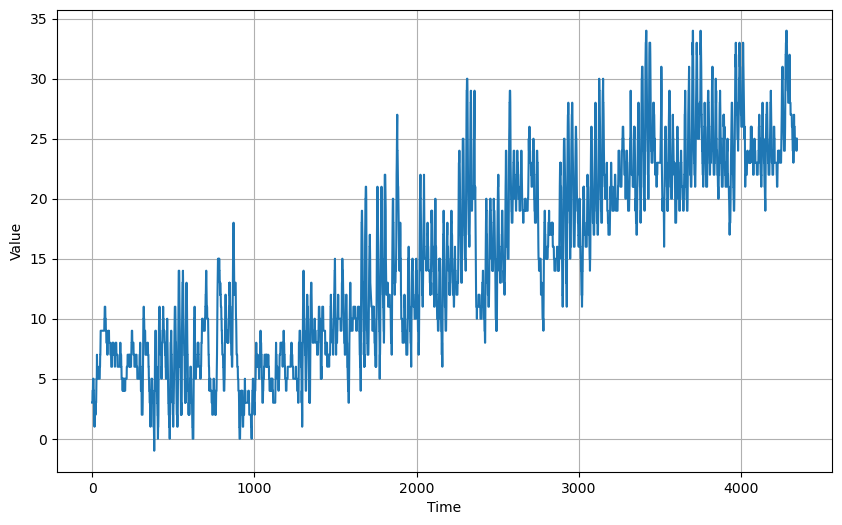

In [13]:
import numpy as np  # 导入NumPy库
import pandas as pd  # 导入Pandas库

# 从CSV文件中读取数据
data_csv = pd.read_csv(r'E:\PythonCode\DeepLearning\Time_Series\data\experment_04\temp.csv', index_col='DATE', na_values='+9999,9')
data = data_csv['TMP']  # 获取'TMP'列数据
data.index = pd.to_datetime(data.index)  # 将索引转换为日期时间格式

# 设置起始时间和结束时间，并对数据进行裁剪
start_time = pd.to_datetime('2019-01-01 00:00:00')
end_time = pd.to_datetime('2019-06-30 23:00:00')
data = data[start_time:end_time]  # 裁剪数据
data = data.dropna()  # 删除缺失值

# 处理数据格式转换和插值操作
data = data.str.split(',', expand=True)[0]  # 按逗号拆分字符串并选择第一部分
data = data.astype('int') / 10  # 转换数据类型并进行数值处理

# 生成日期时间索引并重新索引数据
index = pd.date_range(start='2019-01-01 00:00:00', end='2019-06-30 23:00:00', freq='H')  # 生成日期时间索引
data = data.reindex(index)  # 重新索引数据
data = data.interpolate()  # 执行插值操作
data.info()  # 打印数据信息

series = data.values  # 将数据转换为数组

# 绘制时间序列数据图表
plt.figure(figsize=(10, 6))  # 设置图表大小
plot_series(series)  # 绘制时间序列数据
plt.show()  # 显示图表


In [14]:
class my_Dataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class TrafficDataset:
    def __init__(self, Data=None, sensor=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = Data
        print(self.raw_data.shape)
        self.sensor = sensor
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, window_size=12, split=0.7):
        train_x = []
        train_y = []
     
        test_x = []
        test_y = []

        len_train = int(self.raw_data.shape[0] * split)
        train_seqs = self.data[:len_train]
        remain_len = len_train+int((self.raw_data.shape[0] - len_train)/2)

        # 构建训练集
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size].squeeze())
            train_y.append(train_seqs[i+window_size].squeeze())

        # 构建测试集
        test_seqs=self.data[len_train:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size].squeeze())
            test_y.append(test_seqs[i+window_size].squeeze())
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
       
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, test_set

# 使用TrafficDataset类构建数据集
t = TrafficDataset(series)
train_set, test_set = t.construct_set()
print(train_set.__len__(),test_set.__len__())

# 构建数据加载器
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_worker, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_worker, drop_last=True)


(4344,)
3028 1292


In [15]:
import torch.nn as nn
import torchvision.models as models

class Attention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Attention, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear1(x)
        out = self.tanh(out)
        out = self.linear2(out)
        out = self.softmax(out)
        out = x * out
        return out.sum(dim=1)

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyLSTM, self).__init__()  # 调用父类的构造函数
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # 定义LSTM层
        # 实例化一个ResNet模型，权重为None表示使用随机初始化的权重
        self.resnet = models.resnet18(weights=None)
        
        # 修改ResNet的第一层卷积层，将输入通道数由1变为64，卷积核的大小为(7, 1)，步长为(2, 1)，填充为(3, 0)，不使用偏置
        self.resnet.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0), bias=False)
        
        # 修改ResNet的全连接层，将输出类别数改为num_classes
        self.resnet.fc = nn.Linear(512, batch_size)
    
        self.relu = nn.ReLU()  # 定义激活函数
        self.linear = nn.Linear(hidden_size, batch_size)  # 定义线性层
        self.attention = Attention(batch_size, batch_size)
        self.fc = nn.Linear(batch_size, batch_size)

    def forward(self, x):
        
        out1, _ = self.lstm(x)  # LSTM层的前向传播
     
        
        out1 = self.linear(out1[:, -1, :])  # 取最后一个时间步的输出，通过线性层得到最终输出
        # out1 = self.relu(out1)

        out3 = out1
        out3 = self.fc(out3)
        out3 = self.attention(out3)
       
        
        
        return out3.unsqueeze(1) # 返回输出结果

In [16]:
# 导入所需的库
rmse, mae = [], []  # 用于存储 RMSE 和 MAE 的列表
train_loss=[]  # 用于存储训练损失的列表
test_loss=[]  # 用于存储测试损失的列表

# 设置训练参数
epoch_num = 2500  # 迭代次数
lr = 0.000001  # 学习率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 选择设备（如果有 GPU 则选择 GPU，否则选择 CPU）

# 创建 LSTM 模型实例并将其移到所选设备
model=MyLSTM(1,100,1,5).to(device)

# 定义优化器和损失函数
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.MSELoss()

# 训练循环
for epoch in range(epoch_num):
    loss_list=[]  # 用于存储每个迭代中损失的列表

    # 遍历训练数据
    for x,y in train_loader:
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        out=model(x.unsqueeze(2))

        # 计算损失
        l=loss(out,y.unsqueeze(1))

        # 清除梯度、反向传播、更新权重
        opt.zero_grad()
        l.backward()
        opt.step()
        loss_list.append(l.item())

    # 计算并存储该迭代的平均训练损失
    train_loss_mean = np.mean(loss_list)
    train_loss.append(train_loss_mean)

    loss_list = []  # 重置测试数据的损失列表
    rmse_list, mae_list = [], []  # 用于存储每个批次的 RMSE 和 MAE 的列表

    # 遍历测试数据
    for x,y in test_loader:
        if x.shape[0] < batch_size:  # 检查批次大小是否小于所需大小
            continue
        x, y = x.to(device), y.to(device)

        # 进行预测
        y_hat=model(x.unsqueeze(2))
       
        # 计算损失
        l=loss(y_hat,y.unsqueeze(1))

        # 对预测值和真实值进行反标准化
        y = t.denormalize(y)
        y_hat = t.denormalize(y_hat)

        # 计算并存储 RMSE 和 MAE
        rmse_a, mae_a = utile.eval(y.detach(), y_hat.detach())
        rmse_list.append(rmse_a)
        mae_list.append(mae_a)
        loss_list.append(l.item())

    # 计算并存储该迭代的平均测试损失
    test_loss_mean = np.mean(loss_list)
    test_loss.append(test_loss_mean)

    # 存储该迭代的平均 RMSE 和 MAE
    rmse.append(np.mean(rmse_list))
    mae.append(np.mean(mae_list))

    # 打印该迭代的指标
    print("epoch:", epoch + 1, "\n",
          "train_loss:", train_loss_mean, "test_loss:", test_loss_mean,
          "\n",
          "mae:",np.mean(mae_list),
          "rmse:",np.mean(rmse_list)
          )


epoch: 1 
 train_loss: 0.14606773175976492 test_loss: 0.5069701790809631 
 mae: 24.65031 rmse: 24.886106722650272
epoch: 2 
 train_loss: 0.14524969323114914 test_loss: 0.5066807270050049 
 mae: 24.643112 rmse: 24.87898148465508
epoch: 3 
 train_loss: 0.14457180825146762 test_loss: 0.5063898682594299 
 mae: 24.635883 rmse: 24.871820218935817
epoch: 4 
 train_loss: 0.14570685408332132 test_loss: 0.5060987830162048 
 mae: 24.628645 rmse: 24.864651630571952
epoch: 5 
 train_loss: 0.14486800134181976 test_loss: 0.5058087706565857 
 mae: 24.621439 rmse: 24.85750610521892
epoch: 6 
 train_loss: 0.14503201435912738 test_loss: 0.5055185556411743 
 mae: 24.614212 rmse: 24.85035499088489
epoch: 7 
 train_loss: 0.14365118674256586 test_loss: 0.5052286505699157 
 mae: 24.607004 rmse: 24.843208551283695
epoch: 8 
 train_loss: 0.1449462134729732 test_loss: 0.5049390196800232 
 mae: 24.599789 rmse: 24.8360687829122
epoch: 9 
 train_loss: 0.14283984493125568 test_loss: 0.5046484768390656 
 mae: 24.5925

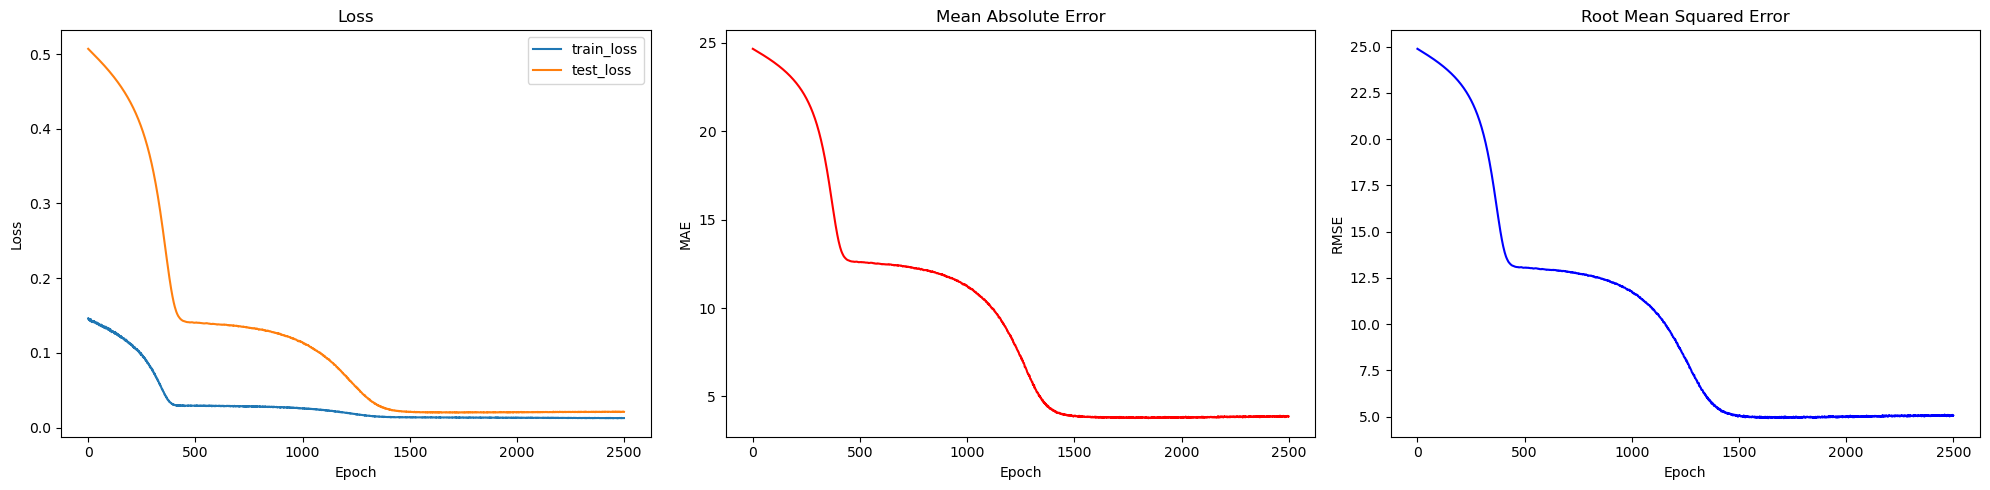

In [17]:
utile.show_result(train_loss,test_loss,mae,rmse)

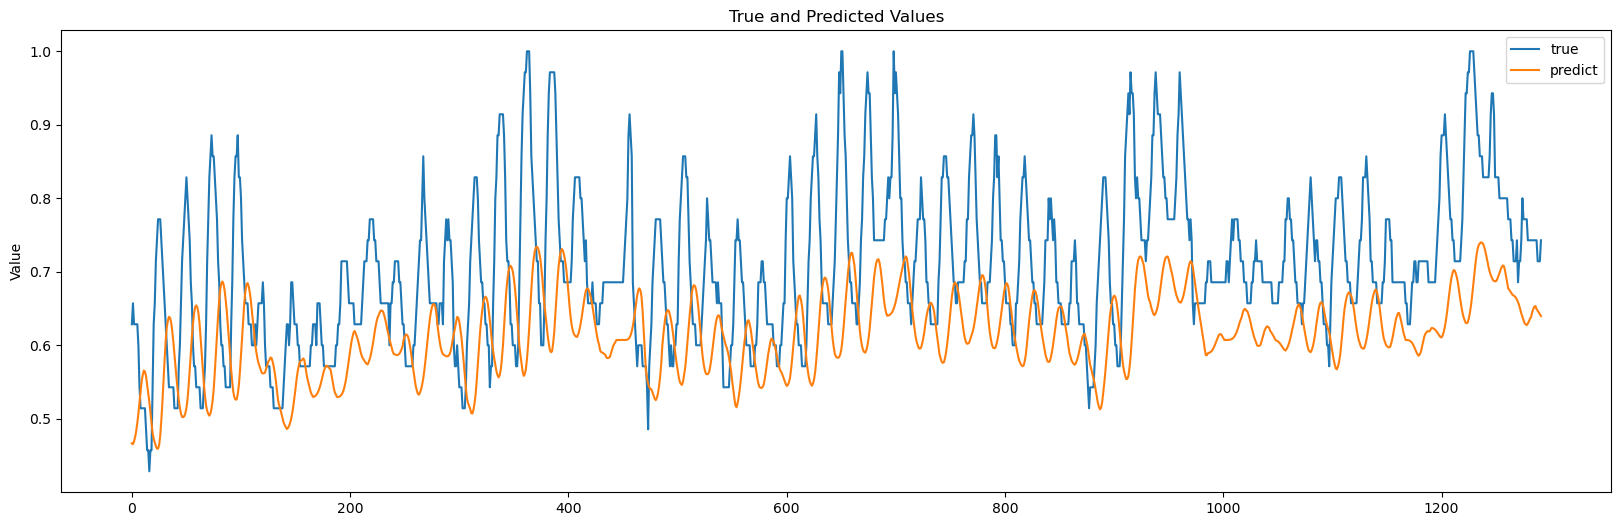

In [18]:
def plot_predictions(net, test_feature, test_label, split_prop, series):
    """
    绘制预测结果和真实结果的图表。

    参数:
    net (ConvModel): 训练好的模型。
    test_feature (Tensor): 测试集特征数据。
    test_label (Tensor): 测试集标签数据。
    split_prop (float): 分割比例。
    series (list): 数据集。

    """
    # 使用训练好的模型进行预测
    test_predict = net(test_feature.unsqueeze(2).to(device)).squeeze().tolist()
    split_point = int(split_prop * int(series.size))
    test_true = test_label

    # 绘制真实值和预测值的对比图表
    plt.figure(figsize=(20, 6))
    plt.plot(test_true, label='true')  # 绘制真实值曲线
    plt.plot(test_predict, label='predict')  # 绘制预测值曲线
    plt.ylabel('Value')  # 设置纵坐标标签
    plt.title('True and Predicted Values')  # 设置图表标题
    plt.legend()  # 添加图例
    plt.show()  # 展示图表
# print(*test_set)
plot_predictions(model, test_set[:][0], test_set[:][1], 0.6, series)